In [1]:
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim, re, spacy, nltk

from pythainlp.corpus import thai_stopwords
from pythainlp import word_tokenize

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

# https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

In [2]:
tokenizer = RegexpTokenizer(r'\w+')

# create English stop words list
stopwords_th = thai_stopwords()

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()

# Prepare Data

In [3]:
import pandas as pd

In [4]:
papers = pd.read_csv('government.csv', header = None, names = ['date','paper_text'])
print(papers.head())
print(papers.shape)

               date                                         paper_text
NaN  4/5/2020 09:03  ได้ข่าวว่าจะชุมนุมใหญ่ ขับไล่รัฐบาลจะบอกว่ารัฐ...
NaN  4/5/2020 09:03      เชิงเทียนฉันมาแล้ว งดด่ารัฐบาลแป้บขอกรี้ดก่อน
NaN  4/5/2020 09:02  เขาชม เพราะชาวบ้านบริจาคอาหารช่วยเหลือค่ะ ไม่ใ...
NaN  4/5/2020 09:01  โรงเรียนมัธยมในเวียดนามเปิดเรียนอีกครั้งวันนี้...
NaN  4/5/2020 09:01  รัฐบาลอิตาลีอนุญาตให้ 20 สโมสรในลีกสูงสุดของปร...
(1193, 2)


# Data cleaning

In [5]:
# create list of text
text_set = []
for i in papers['paper_text']:
    i = str(i)
    i.lower()
    text_set.append(i)
text_set[:5]

['ได้ข่าวว่าจะชุมนุมใหญ่ ขับไล่รัฐบาลจะบอกว่ารัฐบาล รับมือโควิดได้ดี เเบบนี้ก็ได้หรือวะ เเค่เพราะพวกกุไม่ได้เป็นรัฐบาลต้องไล่ คนชั่วช้าสารเลว บ้านเมืองมีวิกฤติพยายามจะซ้ำเติม คุยใหญ่คุยโตรัฐบาลกลัวม็อบ มีเหี้ยไรที่เขาต้องกลัว ออกไปทำเหี้ยไรได้นอกจากไปนั่งฟังเเกนนำเห่า 555',
 'เชิงเทียนฉันมาแล้ว งดด่ารัฐบาลแป้บขอกรี้ดก่อน',
 'เขาชม เพราะชาวบ้านบริจาคอาหารช่วยเหลือค่ะ ไม่ใช่เพราะรัฐบาลหน้าโง่ โปรดแยกแยะด้วยค่ะ อิสลิ่ม ',
 'โรงเรียนมัธยมในเวียดนามเปิดเรียนอีกครั้งวันนี้ (4 พ.ค.) หลังรัฐบาลสั่งปิดมานานกว่า 3 เดือน สกัด #โควิด19\n\nวันนี้ ไม่พบผู้ติดเชื้อใหม่ในประเทศติดต่อกันเป็นวันที่ 17 แล้ว\n\nภาพจาก AFP \n\n#PPTVHD36 #เราไม่ทิ้งกัน #COVID19 ',
 'รัฐบาลอิตาลีอนุญาตให้ 20 สโมสรในลีกสูงสุดของประเทศ เรียกนักเตะทีมชุดใหญ่กลับมาเริ่มซ้อมที่สโมสรได้ตั้งแต่วันจันทร์นี้ &gt; ']

# Prepare data for LDA

In [6]:
# import deepcut
# def split_words (sentence):
#     return deepcut.tokenize(''.join(sentence.lower().split()))

In [7]:
# list for tokenized documents in loop
texts = []

# loop through document list
for i in text_set:
    
    # clean and tokenize document string
    raw = str(i)
    raw = i.lower()
#     tokens = split_words(raw)
    tokens = word_tokenize(raw, engine='longest', keep_whitespace = False)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in stopwords_th]
    
    # remove unimportant word
    del_word = ['\n','\n.',':','@','!', '.', '#', '_','📌','/',')','('
               ,'...','\n-','+','ๆ','ref']
    stopped_tokens = [i for i in tokens if not i in del_word]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # add tokens to list
    texts.append(stemmed_tokens)

In [8]:
texts_out = []
for sent in texts:
    texts_out.append(" ".join(word for word in sent))
texts_out

['ได้ข่าว ว่า จะ ชุมนุม ใหญ่ ขับไล่ รัฐบาล จะ บอก ว่า รัฐบาล รับมือ โค วิด ได้ ดี เเบ บนี้ ก็ได้ หรือ วะ เเค่ เพราะ พวก กุ ไม่ ได้ เป็น รัฐบาล ต้อง ไล่ คนชั่ว ช้า สารเลว บ้านเมือง มี วิกฤติ พยายาม จะ ซ้ำเติม คุย ใหญ่ คุยโต รัฐบาล กลัว ม็อบ มี เหี้ย ไร ที่ เขา ต้อง กลัว ออก ไป ทำ เหี้ย ไร ได้ นอกจาก ไป นั่ง ฟัง เเกน นำ เห่า 555',
 'เชิงเทียน ฉัน มา แล้ว งด ด่า รัฐบาล แป้บ ขอก รี้ ดก่ อน',
 'เขา ชม เพราะ ชาวบ้าน บริจาค อาหาร ช่วยเหลือ ค่ะ ไม่ ใช่ เพราะ รัฐบาล หน้า โง่ โปรด แยกแยะ ด้วย ค่ะ อิส ลิ่ม',
 'โรงเรียนมัธยม ใน เวียดนาม เปิดเรียน อีกครั้ง วัน นี้ 4 พ.ค. หลัง รัฐบาล สั่ง ปิด มา นาน กว่า 3 เดือน สกัด โค วิด 19 วันนี้ ไม่ พบ ผู้ ติดเชื้อ ใหม่ ในประเทศ ติดต่อกัน เป็น วันที่ 17 แล้ว ภาพ จาก afp \n# pptvhd36 เรา ไม่ ทิ้ง กัน covid19',
 'รัฐบาล อิตาลี อนุญาต ให้ 20 สโมสร ใน ลีก สูงสุด ของ ประเทศ เรียก นักเตะ ทีม ชุด ใหญ่ กลับมา เริ่ม ซ้อม ที่ สโมสร ได้ ตั้งแต่ วัน จันทร์ นี้ & gt ;',
 'thawa85736827 exo kim monster redbuffalofr apple47719152 pannika fwp รัฐบาล แจก ถ้วนหน้า ไหม ล่ะ อี ควา

## Create the document-word matrix

In [9]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words=stopwords_th,             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern= r"[ก-๙a-zA-Z']+",  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(texts_out)

## Check the Sparsicity

In [10]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  2.3721222635918826 %


# Build LDA model

In [11]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


## Diagnose model performance with perplexity and log-likelihood

In [12]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -63598.179800928505
Perplexity:  261.28349443030885
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


# GridSearch with LDA model

In [28]:
# Define Search Param
search_params = {'n_components': [3, 5,10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [29]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 3}
Best Log Likelihood Score:  -13461.937275830485
Model Perplexity:  204.54029227429606


## Visualize LDA model

In [30]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

/Users/phatarasutarasuwan/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                 x            y  topics  cluster       Freq
topic                                                      
1     -1015.700562  1338.981201       1        1  44.251154
0      -387.996002  -373.316162       2        1  30.785028
2     -2184.745605   -60.565800       3        1  24.963819, topic_info=    Category        Freq    Term       Total  loglift  logprob
321  Default  110.000000      โค  110.000000  30.0000  30.0000
80   Default  162.000000     ด่า  162.000000  29.0000  29.0000
207  Default  103.000000     วิด  103.000000  28.0000  28.0000
262  Default   97.000000      อี   97.000000  27.0000  27.0000
274  Default  280.000000    เงิน  280.000000  26.0000  26.0000
..       ...         ...     ...         ...      ...      ...
274   Topic3   33.120489    เงิน  280.703166  -0.7494  -4.4558
309   Topic3   27.095224     แจก  134.699100  -0.2159  -4.6566
90    Topic3   23.116988  ตัวเอง   70.936441   0.2665  -4.8154
127   Topic3   21.760056     บาท   49.621745   0.5634  -4.8759
316   Topic3   21.281891     แม่   59.303967   0.3629  -4.8981

[197 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
2         1  0.973685       luvluvhk
3         1  0.954870  matichononlin
4         3  0.963795           news
7         3  0.952558       thairath
10        2  0.986345              ก
...     ...       ...            ...
339       2  0.970535          ไวรัส
340       1  0.865978            ไหม
340       2  0.120275            ไหม
343       1  0.157302            ไอ้
343       3  0.838947            ไอ้

[266 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

# Topic Keyword

In [33]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(papers))]

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,covid,hengsuaycountri,luvluvhk,matichononlin,news,redbuffalofr,somchaikp,thairath,vat,voicetvoffici,...,ได้เงิน,ไทย,ไม่ต้อง,ไร้,ไล่,ไวรัส,ไหม,ไหว,ไอ,ไอ้
Topic0,17.787941,0.343938,0.364267,0.345927,0.340650,1.350380,0.343651,0.340143,0.665921,0.391631,...,11.48693,57.367304,0.369422,5.223310,1.817867,16.207269,5.402847,5.353068,16.083689,0.343904
Topic1,4.853159,7.740684,16.242945,12.286302,0.363178,0.366889,17.707164,0.369445,14.943926,2.803324,...,26.29690,48.145574,9.384630,10.335785,0.745553,0.458703,37.179537,3.556740,3.959755,6.289261
Topic2,0.358900,4.915378,0.392789,0.367771,17.296172,13.282731,1.949185,14.290413,0.390154,9.805045,...,1.21617,4.487121,35.245948,2.440904,15.436580,0.334028,0.417616,3.090192,1.956556,32.366834


# Top 15 keywords each topic

In [34]:
import numpy as np
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in best_lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=20)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,รัฐบาล,ด่า,โค,วิด,รัฐ,ทำ,บาล,กุ,ไทย,ดี,หน้า,อะ,เหี้ย,ประชาชน,ตอนนี้,คน,ประ,ประเทศ,ค,มาตรการ
Topic 1,รัฐบาล,คน,เงิน,ทำ,ประชาชน,เค้า,ภาษี,แจก,คณะ,เรื่อง,โง่,ก้าวหน้า,ซื้อ,ปชช,แบบนี้,สลิ่ม,ไทย,หรอ,บริจาค,อะ
Topic 2,รัฐบาล,อี,คน,ผม,หยุด,รัฐ,ไม่ต้อง,ล้าน,เงิน,เหมือน,ชุด,ไอ้,พี่,ประเทศ,รู้,ส้นตีน,รอ,เล่น,ดี,บาล


## Wordcloud ภาษาไทย

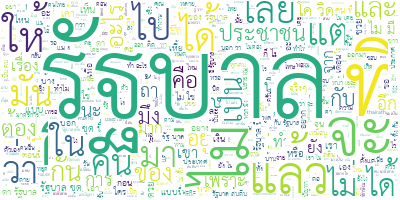

In [169]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(texts_out)

# path ของ font
path = 'THSarabunNew.ttf'

regexp = r"[ก-๙a-zA-Z']+"

# Create a WordCloud object
wordcloud = WordCloud(font_path=path, background_color="white", max_words=5000, 
                      contour_width=3, contour_color='steelblue',
                     regexp=regexp)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

